In [1]:
import numpy as np
import os

# GPU가 없는 시스템에서는 자동으로 CPU 모드로 실행됨.

# CUDA_VISIBLE_DEVICES 환경 변수를 설정하여 사용 가능한 GPU를 지정
# '1'번 GPU를 사용하도록 설정 (0번부터 시작하여 번호가 매겨짐)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# TF_FORCE_GPU_ALLOW_GROWTH 환경 변수를 설정하여 TensorFlow가 GPU 메모리를 동적으로 사용할 수 있게 함
# 기본적으로 TensorFlow는 모든 GPU 메모리를 할당하지만, 이 설정을 통해 필요한 만큼만 할당하게 함
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# 인식할 동작 목록 정의
actions = [
    'good',
    'bad',
    'one',
    'two',
    'three'
    'four',
    'five'
]

# 각 동작에 해당하는 데이터를 로드하여 하나의 배열로 연결
data = np.concatenate([
    np.load('dataset/seq_good_1718526787.npy'),
    np.load('dataset/seq_bad_1718526787.npy'),
    np.load('dataset/seq_one_1716892952.npy'),
    np.load('dataset/seq_two_1716892952.npy'),
    np.load('dataset/seq_three_1716892952.npy'),
    np.load('dataset/seq_four_1718526787.npy'),
    np.load('dataset/seq_five_1718526787.npy')
], axis=0) # 첫 번째 축(axis=0)을 따라 데이터를 연결

# 연결된 데이터의 형태 출력
data.shape # 예를 들어, (900, 30, 68)처럼 연결된 데이터의 차원 정보를 출력

(5731, 30, 100)

In [3]:
# 데이터에서 입력 데이터(x_data)와 라벨(labels) 분리
# x_data는 마지막 축을 제외한 모든 데이터를 포함
# labels는 마지막 축의 첫 번째 값을 사용하여 각 시퀀스의 라벨로 설정
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

# 분리된 데이터의 형태 출력
print(x_data.shape)   # 예를 들어, (900, 30, 67)
print(labels.shape)   # 예를 들어, (900,)

(5731, 30, 99)
(5731,)


In [4]:
# TensorFlow Keras의 to_categorical을 사용하여 라벨을 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

# 원-핫 인코딩된 라벨 데이터 생성
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape  # 예를 들어, (900, 3)

(5731, 6)

In [5]:
# sklearn의 train_test_split을 사용하여 데이터셋을 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split

# 데이터 타입을 float32로 변환
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# 학습 데이터와 검증 데이터로 분할 (10%는 검증 데이터로 사용)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

# 분할된 데이터셋의 형태 출력
print(x_train.shape, y_train.shape)  # 예를 들어, (810, 30, 67) (810, 3)
print(x_val.shape, y_val.shape)      # 예를 들어, (90, 30, 67) (90, 3)

(5157, 30, 99) (5157, 6)
(574, 30, 99) (574, 6)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델을 Sequential 형태로 정의
model = Sequential([
    # 첫 번째 LSTM 레이어
    # 유닛 수: 64, 활성화 함수: ReLU, 입력 형태: (시퀀스 길이, 피처 수)
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    # 두 번째 Dense 레이어
    # 유닛 수: 32, 활성화 함수: ReLU
    Dense(32, activation='relu'),
    # 세 번째 Dense 레이어 (출력 레이어)
    # 유닛 수: 인식할 동작의 수, 활성화 함수: 소프트맥스
    Dense(len(actions), activation='softmax')
])


C:\Users\by130\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          41,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,262 (172.90 KB)

 Trainable params: 44,262 (172.90 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# 모델 학습
history = model.fit(
    x_train,              # 학습 데이터
    y_train,              # 학습 라벨
    validation_data=(x_val, y_val),  # 검증 데이터 및 라벨
    epochs=200,           # 총 학습 에포크 수
    callbacks=[
        # ModelCheckpoint 콜백: 최적의 모델을 저장
        ModelCheckpoint(
            'models/model.keras',  # 모델 파일 저장 경로
            monitor='val_acc',         # 검증 정확도를 모니터링
            verbose=1,                 # 저장 시 메시지 출력
            save_best_only=True,       # 최상의 검증 정확도를 가진 모델만 저장
            mode='auto'                # 최적화 기준 모드 자동 설정
        ),
        # ReduceLROnPlateau 콜백: 학습 속도 조정
        ReduceLROnPlateau(
            monitor='val_acc',         # 검증 정확도를 모니터링
            factor=0.5,                # 학습 속도를 줄이는 비율
            patience=50,               # 50 에포크 동안 개선이 없으면 학습 속도를 줄임
            verbose=1,                 # 학습 속도 조정 시 메시지 출력
            mode='auto'                # 최적화 기준 모드 자동 설정
        )
    ]
)


Epoch 1/200
158/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.4580 - loss: 21.4487
Epoch 1: val_acc improved from -inf to 0.42857, saving model to models/model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - acc: 0.4580 - loss: 21.4293 - val_acc: 0.4286 - val_loss: 30.1881 - learning_rate: 0.0010
Epoch 2/200
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.4996 - loss: 17.8691
Epoch 2: val_acc did not improve from 0.42857
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.4996 - loss: 17.8691 - val_acc: 0.3728 - val_loss: 63.7083 - learning_rate: 0.0010
Epoch 3/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.3402 - loss: 96.9003
Epoch 3: val_acc did not improve from 0.42857
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.3404 - loss: 96.7084 - val_acc: 0.4094 - val_loss: 21.0768 - learning_rate: 0.0010
Epoch 4/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.3986 - loss: 30.4492
Epoch 4: val_acc improved from 0.42857 to 0.46864, saving model to models/model.keras
1

Epoch 25/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7341 - loss: 2.1457
Epoch 25: val_acc did not improve from 0.79791
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.7341 - loss: 2.1457 - val_acc: 0.7927 - val_loss: 1.6932 - learning_rate: 0.0010
Epoch 26/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7514 - loss: 2.3164
Epoch 26: val_acc did not improve from 0.79791
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.7511 - loss: 2.3230 - val_acc: 0.7003 - val_loss: 1.2600 - learning_rate: 0.0010
Epoch 27/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7386 - loss: 1.9708
Epoch 27: val_acc did not improve from 0.79791
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.7386 - loss: 1.9716 - val_acc: 0.7561 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 28/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7284 - loss: 2.3438
Epoch 28: val_acc did not improve from 0.79791
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.7285 - loss: 2.3408 - val_acc

Epoch 50/200
160/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8387 - loss: 1.0195
Epoch 50: val_acc did not improve from 0.85192
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.8386 - loss: 1.0230 - val_acc: 0.7631 - val_loss: 2.9839 - learning_rate: 0.0010
Epoch 51/200
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8128 - loss: 1.7058
Epoch 51: val_acc improved from 0.85192 to 0.85540, saving model to models/model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.8129 - loss: 1.7008 - val_acc: 0.8554 - val_loss: 0.7375 - learning_rate: 0.0010
Epoch 52/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8378 - loss: 0.8085
Epoch 52: val_acc did not improve from 0.85540
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.8378 - loss: 0.8093 - val_acc: 0.8240 - val_loss: 1.5291 - learning_rate: 0.0010
Epoch 53/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8288 - loss: 1.0230
Epoch 53: val_acc improved from 0.85540 to 0.89199, saving model to models/model.keras


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9054 - loss: 0.3996
Epoch 74: val_acc did not improve from 0.92683
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - acc: 0.9054 - loss: 0.3997 - val_acc: 0.7962 - val_loss: 3.2019 - learning_rate: 0.0010
Epoch 75/200
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8606 - loss: 1.6820
Epoch 75: val_acc did not improve from 0.92683
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.8610 - loss: 1.6714 - val_acc: 0.9251 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 76/200
158/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9068 - loss: 0.4737
Epoch 76: val_acc did not improve from 0.92683
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9065 - loss: 0.4764 - val_acc: 0.8362 - val_loss: 2.0530 - learning_rate: 0.0010
Epoch 77/200
160/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8754 - loss: 0.8129
Epoch 77: val_acc did not improve from 0.92683
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8755 - loss: 0.8111 - val_acc: 0.9024 - va

Epoch 99/200
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8978 - loss: 0.2822
Epoch 99: val_acc did not improve from 0.92683
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - acc: 0.8979 - loss: 0.2824 - val_acc: 0.8955 - val_loss: 0.2156 - learning_rate: 0.0010
Epoch 100/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9090 - loss: 0.3402
Epoch 100: val_acc did not improve from 0.92683
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.9089 - loss: 0.3416 - val_acc: 0.9251 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 101/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9293 - loss: 0.2289
Epoch 101: val_acc improved from 0.92683 to 0.93728, saving model to models/model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.9292 - loss: 0.2299 - val_acc: 0.9373 - val_loss: 0.1584 - learning_rate: 0.0010
Epoch 102/200
160/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9372 - loss: 0.1692
Epoch 102: val_acc improved from 0.93728 to 0.94599, saving model to models/model.

157/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9641 - loss: 0.0913
Epoch 123: val_acc improved from 0.96341 to 0.96690, saving model to models/model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9642 - loss: 0.0914 - val_acc: 0.9669 - val_loss: 0.0801 - learning_rate: 0.0010
Epoch 124/200
158/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9682 - loss: 0.0914
Epoch 124: val_acc did not improve from 0.96690
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9681 - loss: 0.0914 - val_acc: 0.9617 - val_loss: 0.0883 - learning_rate: 0.0010
Epoch 125/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9643 - loss: 0.0925
Epoch 125: val_acc did not improve from 0.96690
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.9643 - loss: 0.0925 - val_acc: 0.9599 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 126/200
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9671 - loss: 0.0818
Epoch 126: val_acc did not improve from 0.96690
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - ac

Epoch 147/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9718 - loss: 0.0762
Epoch 147: val_acc did not improve from 0.99129
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9717 - loss: 0.0764 - val_acc: 0.9617 - val_loss: 0.0923 - learning_rate: 0.0010
Epoch 148/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9656 - loss: 0.0881
Epoch 148: val_acc did not improve from 0.99129
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9656 - loss: 0.0880 - val_acc: 0.9756 - val_loss: 0.0841 - learning_rate: 0.0010
Epoch 149/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9797 - loss: 0.0500
Epoch 149: val_acc did not improve from 0.99129
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.9797 - loss: 0.0500 - val_acc: 0.9774 - val_loss: 0.0655 - learning_rate: 0.0010
Epoch 150/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9836 - loss: 0.0490
Epoch 150: val_acc did not improve from 0.99129
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.9835 - loss: 0.0491 -

162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - acc: 0.9972 - loss: 0.0103 - val_acc: 0.9547 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 172/200
160/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9871 - loss: 0.0323
Epoch 172: val_acc did not improve from 0.99826
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.9872 - loss: 0.0321 - val_acc: 0.9983 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 173/200
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9990 - loss: 0.0049
Epoch 173: val_acc did not improve from 0.99826
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.9990 - loss: 0.0049 - val_acc: 0.9983 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 174/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9987 - loss: 0.0034
Epoch 174: val_acc improved from 0.99826 to 1.00000, saving model to models/model.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9987 - loss: 0.0034 - val_acc: 1.0000 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 175/200
159/162 ━━━━━━━━━━━

Epoch 196/200
158/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8425 - loss: 0.3589
Epoch 196: val_acc did not improve from 1.00000
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8422 - loss: 0.3591 - val_acc: 0.8606 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 197/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8339 - loss: 0.3566
Epoch 197: val_acc did not improve from 1.00000
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.8339 - loss: 0.3566 - val_acc: 0.8519 - val_loss: 0.3196 - learning_rate: 0.0010
Epoch 198/200
160/162 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8467 - loss: 0.3387
Epoch 198: val_acc did not improve from 1.00000
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.8465 - loss: 0.3389 - val_acc: 0.8206 - val_loss: 0.3517 - learning_rate: 0.0010
Epoch 199/200
161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8295 - loss: 0.3530
Epoch 199: val_acc did not improve from 1.00000
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.8296 - loss: 0.3529 -

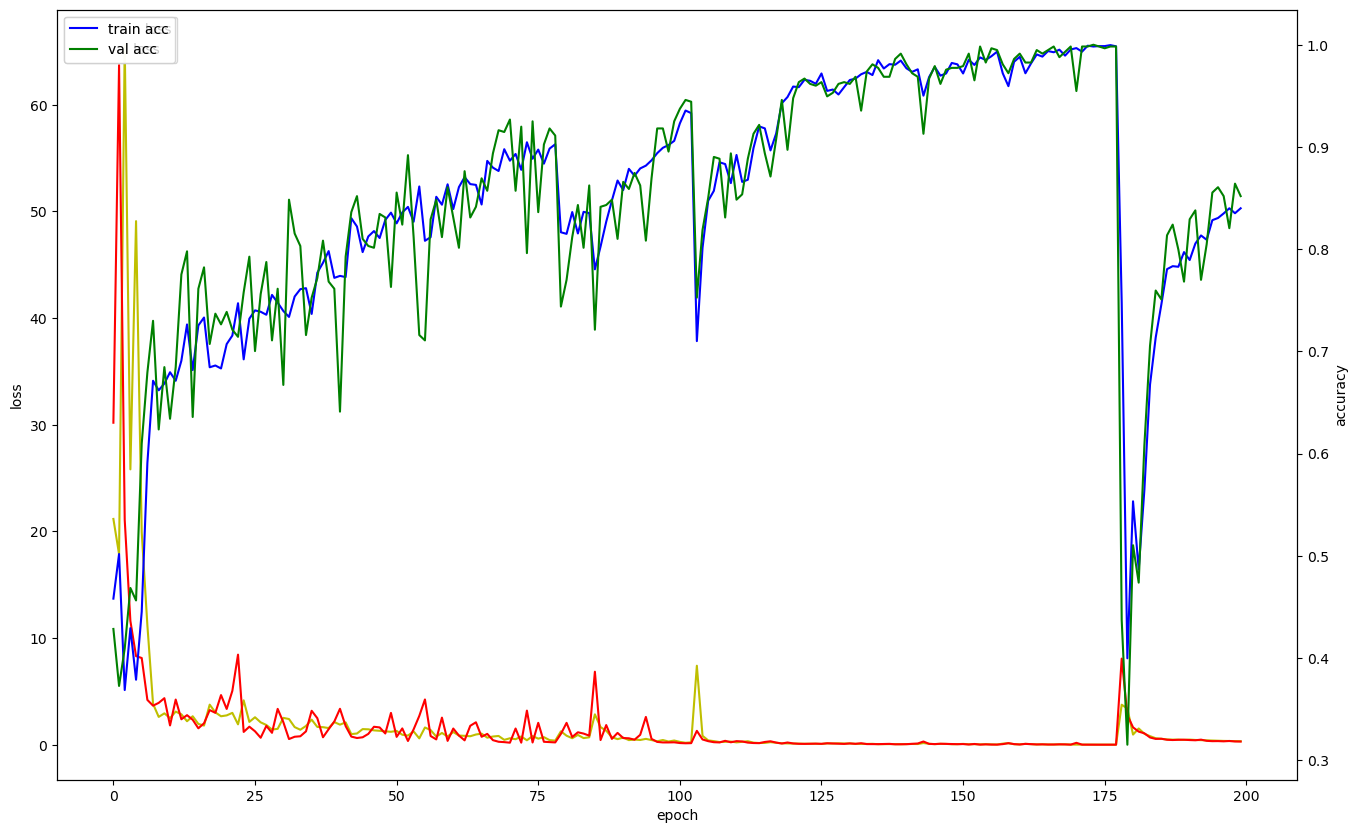

In [8]:
import matplotlib.pyplot as plt

# 그래프 생성
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

# 손실 그래프 설정
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

# 정확도 그래프 설정
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

# 그래프 출력
plt.show()


In [ ]:
# 데이터 증강하기

In [10]:
import numpy as np

# 데이터 증강 함수들
def add_noise(data, noise_factor=0.01):
    noise = np.random.randn(*data.shape) * noise_factor
    augmented_data = data + noise
    return augmented_data

def time_warp(data, warp_factor=1.1):
    from scipy.interpolate import interp1d
    seq_len, n_features = data.shape
    new_length = int(seq_len * warp_factor)
    interp_func = interp1d(np.arange(seq_len), data, axis=0, kind='linear')
    warped_data = interp_func(np.linspace(0, seq_len-1, new_length))
    return warped_data

def random_crop(data, crop_length):
    seq_len, n_features = data.shape
    start = np.random.randint(0, seq_len - crop_length + 1)
    cropped_data = data[start:start + crop_length]
    return cropped_data

def shift_sequence(data, shift_max):
    shift = np.random.randint(-shift_max, shift_max)
    shifted_data = np.roll(data, shift, axis=0)
    if shift > 0:
        shifted_data[:shift] = 0
    elif shift < 0:
        shifted_data[shift:] = 0
    return shifted_data

augmented_data = []
augmented_labels = []
for x, y in zip(x_train, y_train):
    augmented_data.append(add_noise(x))
    augmented_labels.append(y)
    
    warped_x = time_warp(x)
    if warped_x.shape[0] == x.shape[0]:  # 길이가 같을 때만 추가
        augmented_data.append(warped_x)
        augmented_labels.append(y)
    
    cropped_x = random_crop(x, crop_length=x.shape[0])
    if cropped_x.shape[0] == x.shape[0]:  # 길이가 같을 때만 추가
        augmented_data.append(cropped_x)
        augmented_labels.append(y)
    
    augmented_data.append(shift_sequence(x, shift_max=5))
    augmented_labels.append(y)

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

x_train_augmented = np.concatenate((x_train, augmented_data), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

print(f"x_train_augmented shape: {x_train_augmented.shape}")
print(f"y_train_augmented shape: {y_train_augmented.shape}")

# 학습 데이터와 검증 데이터 나누기
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    x_train_augmented, y_train_augmented, test_size=0.1, random_state=2021)

print(f"x_train_final shape: {x_train_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"x_val_final shape: {x_val_final.shape}")
print(f"y_val_final shape: {y_val_final.shape}")



x_train_augmented shape: (20628, 30, 99)
y_train_augmented shape: (20628, 6)
x_train_final shape: (18565, 30, 99)
y_train_final shape: (18565, 6)
x_val_final shape: (2063, 30, 99)
y_val_final shape: (2063, 6)


In [11]:
# 모델 학습
history = model.fit(
    x_train_final,              # 학습 데이터
    y_train_final,              # 학습 라벨
    validation_data=(x_val_final, y_val_final),  # 검증 데이터 및 라벨
    epochs=200,                 # 총 학습 에포크 수
    callbacks=[
        ModelCheckpoint(
            'models/model.keras',
            monitor='val_acc',
            verbose=1,
            save_best_only=True,
            mode='auto'
        ),
        ReduceLROnPlateau(
            monitor='val_acc',
            factor=0.5,
            patience=50,
            verbose=1,
            mode='auto'
        )
    ]
)



Epoch 1/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8096 - loss: 0.4614
Epoch 1: val_acc improved from -inf to 0.80368, saving model to models/model.keras
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.8096 - loss: 0.4613 - val_acc: 0.8037 - val_loss: 0.4200 - learning_rate: 0.0010
Epoch 2/200
579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8081 - loss: 0.4022
Epoch 2: val_acc improved from 0.80368 to 0.82065, saving model to models/model.keras
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.8081 - loss: 0.4022 - val_acc: 0.8206 - val_loss: 0.3824 - learning_rate: 0.0010
Epoch 3/200
581/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8325 - loss: 0.3442
Epoch 3: val_acc improved from 0.82065 to 0.85167, saving model to models/model.keras
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.8325 - loss: 0.3442 - val_acc: 0.8517 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 4/200
579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8398 - loss: 0.3317
Epoch 4: val_acc 

581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.9185 - loss: 0.1944 - val_acc: 0.9336 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 25/200
579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9034 - loss: 0.3769
Epoch 25: val_acc did not improve from 0.93359
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.9032 - loss: 0.3775 - val_acc: 0.8294 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 26/200
578/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8677 - loss: 0.2713
Epoch 26: val_acc did not improve from 0.93359
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.8678 - loss: 0.2712 - val_acc: 0.8662 - val_loss: 0.2675 - learning_rate: 0.0010
Epoch 27/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8996 - loss: 0.2292
Epoch 27: val_acc did not improve from 0.93359
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.8996 - loss: 0.2291 - val_acc: 0.9118 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 28/200
581/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9096 - loss: 

Epoch 49/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.2848 - loss: 1.3571
Epoch 49: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - acc: 0.2848 - loss: 1.3571 - val_acc: 0.3059 - val_loss: 1.3513 - learning_rate: 0.0010
Epoch 50/200
578/581 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.2879 - loss: 1.3581
Epoch 50: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.2879 - loss: 1.3581 - val_acc: 0.3059 - val_loss: 1.3506 - learning_rate: 0.0010
Epoch 51/200
579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.2851 - loss: 1.3590
Epoch 51: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.2851 - loss: 1.3590 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 0.0010
Epoch 52/200
577/581 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.2879 - loss: 1.3582
Epoch 52: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - acc: 0.2879 - loss: 1.3582 - val

Epoch 74/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2872 - loss: 1.3599
Epoch 74: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2872 - loss: 1.3599 - val_acc: 0.2894 - val_loss: 1.3505 - learning_rate: 0.0010
Epoch 75/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2898 - loss: 1.3592
Epoch 75: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2898 - loss: 1.3592 - val_acc: 0.2894 - val_loss: 1.3505 - learning_rate: 0.0010
Epoch 76/200
579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2897 - loss: 1.3594
Epoch 76: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2897 - loss: 1.3593 - val_acc: 0.2894 - val_loss: 1.3507 - learning_rate: 0.0010
Epoch 77/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2838 - loss: 1.3602
Epoch 77: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2838 - loss: 1.3601 - val_acc

579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2895 - loss: 1.3567
Epoch 98: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2895 - loss: 1.3567 - val_acc: 0.3059 - val_loss: 1.3505 - learning_rate: 5.0000e-04
Epoch 99/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2862 - loss: 1.3588
Epoch 99: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2862 - loss: 1.3588 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 5.0000e-04
Epoch 100/200
577/581 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.2862 - loss: 1.3589
Epoch 100: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.2863 - loss: 1.3589 - val_acc: 0.3059 - val_loss: 1.3505 - learning_rate: 5.0000e-04
Epoch 101/200
577/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2834 - loss: 1.3572
Epoch 101: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2835 - loss: 1.3572 - val

581/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2831 - loss: 1.3588
Epoch 122: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2831 - loss: 1.3588 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 5.0000e-04
Epoch 123/200
578/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2892 - loss: 1.3593
Epoch 123: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - acc: 0.2892 - loss: 1.3593 - val_acc: 0.3059 - val_loss: 1.3505 - learning_rate: 5.0000e-04
Epoch 124/200
576/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2801 - loss: 1.3584
Epoch 124: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - acc: 0.2801 - loss: 1.3584 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 5.0000e-04
Epoch 125/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2899 - loss: 1.3579
Epoch 125: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2899 - loss: 1.3579 - 

579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2925 - loss: 1.3559
Epoch 146: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2925 - loss: 1.3559 - val_acc: 0.3059 - val_loss: 1.3505 - learning_rate: 2.5000e-04
Epoch 147/200
579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2875 - loss: 1.3577
Epoch 147: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2875 - loss: 1.3577 - val_acc: 0.3059 - val_loss: 1.3505 - learning_rate: 2.5000e-04
Epoch 148/200
578/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2821 - loss: 1.3579
Epoch 148: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2821 - loss: 1.3579 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 2.5000e-04
Epoch 149/200
579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2878 - loss: 1.3593
Epoch 149: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2878 - loss: 1.3593 - v

578/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2905 - loss: 1.3584
Epoch 170: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2905 - loss: 1.3584 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 2.5000e-04
Epoch 171/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2840 - loss: 1.3598
Epoch 171: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - acc: 0.2840 - loss: 1.3598 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 2.5000e-04
Epoch 172/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2899 - loss: 1.3577
Epoch 172: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2899 - loss: 1.3577 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 2.5000e-04
Epoch 173/200
580/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2886 - loss: 1.3599
Epoch 173: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - acc: 0.2886 - loss: 1.3599 - v

579/581 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.2855 - loss: 1.3586
Epoch 194: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - acc: 0.2855 - loss: 1.3586 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 1.2500e-04
Epoch 195/200
577/581 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.2885 - loss: 1.3580
Epoch 195: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - acc: 0.2885 - loss: 1.3580 - val_acc: 0.3059 - val_loss: 1.3504 - learning_rate: 1.2500e-04
Epoch 196/200
581/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2873 - loss: 1.3579
Epoch 196: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2873 - loss: 1.3579 - val_acc: 0.3059 - val_loss: 1.3505 - learning_rate: 1.2500e-04
Epoch 197/200
578/581 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.2895 - loss: 1.3586
Epoch 197: val_acc did not improve from 0.95153
581/581 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - acc: 0.2895 - loss: 1.3586 - 

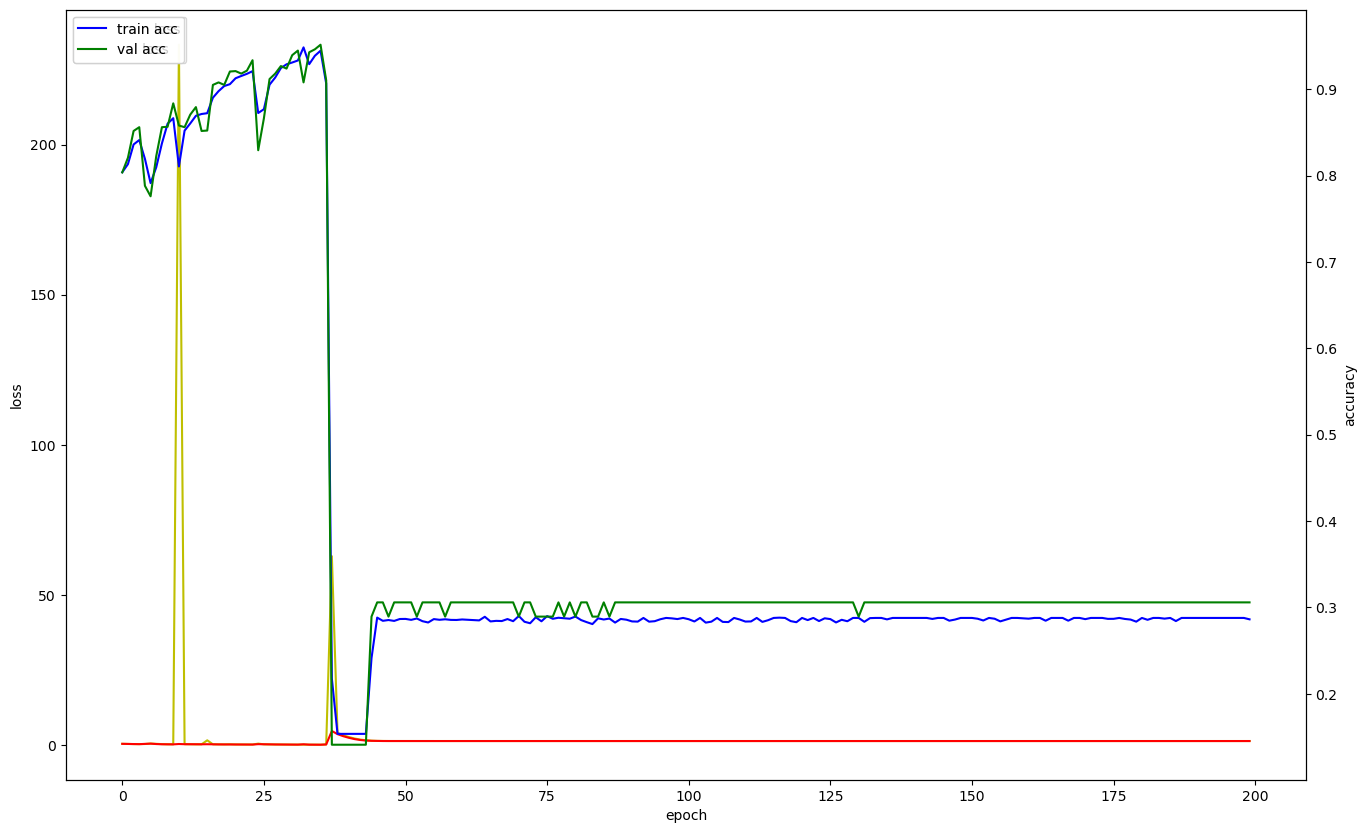

In [12]:
# 그래프 생성
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

# 손실 그래프 설정
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

# 정확도 그래프 설정
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

# 그래프 출력
plt.show()


In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

# 저장된 모델 로드
model = load_model('models/model.keras')

# 검증 데이터를 사용하여 모델의 예측 수행
y_pred = model.predict(x_val)

# 다중 라벨 혼동 행렬 계산
confusion_matrices = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

# 다중 라벨 혼동 행렬 출력
confusion_matrices


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


array([[[168,   0],
        [  0,  69]],

       [[145,   0],
        [  0,  92]],

       [[161,   0],
        [  0,  76]]], dtype=int64)

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model
import os

# 모델 파일 경로 정의
model_file = 'models/model.keras'

try:
    # 파일 존재 여부 확인
    if os.path.exists(model_file):
        # 모델 로드
        model = load_model(model_file)

        # 검증 데이터에 대한 예측 수행
        y_pred = model.predict(x_val)

        # 다중 라벨 혼동 행렬 계산
        confusion_matrices = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

        # 혼동 행렬 출력
        print(confusion_matrices)
    else:
        raise FileNotFoundError(f"모델 파일 '{model_file}'을 찾을 수 없습니다.")
except Exception as e:
    print("오류가 발생했습니다:", e)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[[168   0]
  [  0  69]]

 [[145   0]
  [  0  92]]

 [[161   0]
  [  0  76]]]
